# 1.Initial Approach

To predict flight delays, we initially created classification models to categorize flights as "delayed", "on-time", or "cancelled" based on the 2013 historical flight data set. Using the target variable "total_delay" we set a threshold of 20 minutes; if the total_delay exceeded it, the flight would be classified as delayed and others on-time. We trained models such as Random Forests, Support Vectors Machines and Neural Networks to analyze key flight attributes such as departure time, airline carrier, origin, destination and historical delays.


After trying various methods, we decided not to continue with this approach, as classification models oversimplified the problem by essentially reducing delays down to discrete categories rather finding the continuous nature of delays.


Instead, we shifted our focus on creating regression based models that can accurately predict delay duration, providing more insights for airlines and airports.


Upon completing of both the regressors and classifiers models, we identified opportunites to enhance our regressors by incorporating additional data sources.
To improve the robustness of our predictions, we scraped weather data from the OpenWeatherMap API and integrated it into our dataset. By including weather related variables such as temperature, humidity, windspeed, and precipitation, we aimed to find what external factors significatly impact flight delays. However, OpenWeatherMap API only allowed 1000 calls per day. Due to this constraint we tried to sample 1000 rows. This caused datset imbalance and there was not enough data to train off of causing underfitting.

Later on within the project, we performed log transformation on total_delay to deal with outliers and negative values so we can use poisson regression with xgboost. However, the results didnt provide anything meaningful because its assuming total_delay is a count value when its in minutes. It is calculating the probability of the log transformation of total_delay reaching to the predicted total_delay which does not provide anything meaningful.


# Note:
In this Failed_Process.ipynb, we go through our initial process of creating classification and regression models before changing our approach in ITEC4305_Group_Project.ipynb



# Classification Models

The objective is creating various machine learning models / algorithms to test their precision recall, AUC-ROC, and f1-scores for predicting total delays to see which one classifies the greatest for flights greater then 20 minutes



# Machine Learning Algorithms:
Random Forest Classifier

Support Vector Machine (SVM) Classifier

Feedforward Neural Network (FFNN)

# Evaluation Metrics:
Precision: Measures the proportion of correctly predicted delayed flights out of all flights predicted as delayed.

Recall: Measures the proportion of correctly predicted delayed flights out of all actual delayed flights.

AUC-ROC: Evaluates the model's ability to distinguish between delayed and non-delayed flights across different thresholds.

F1-Score: Combines precision and recall into a single metric, providing a balanced measure of model performance.

# 1. Random Forest Classifier
About 1 minute runtime

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, precision_score,recall_score



df=pd.read_csv('flights_EDA.csv')

X= df.drop(columns=['total_delay', 'id', 'time_hour', 'name'])
y=(df['total_delay']> 20).astype(int)


# categorical columns and numerical
categorical_cols =['carrier', 'origin', 'dest', 'flight_status', 'flight', 'tailnum']
num_cols =['dep_time', 'arr_time', 'air_time', 'distance']

#spliting the data 
X_train, X_temp, y_train, y_temp = train_test_split(X,y, test_size=0.3, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=1)

# preprocessing pipleine to train the model
preprocessor = ColumnTransformer(
    transformers=[('num', StandardScaler(), num_cols),
                  ('cat', OneHotEncoder(handle_unknown='ignore'),categorical_cols)]
)

#create the pipeline
pipeline = Pipeline(steps=[
    ('preprpcessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=5, random_state=1))
])





In [3]:
#train the random forest classifier
pipeline.fit(X_train, y_train)
print('done training')


done training


#Training the model on the validation set
given the results we can retrain or test the model on the test set to see if the model is performing well

In [4]:
y_prediction = pipeline.predict(X_val)
#checking the metrics to see if retraining is needed

print(f"Accuracy: {accuracy_score(y_val, y_prediction):.4f}")
print(f"Classification report:\n {classification_report(y_val, y_prediction)}")
print(f"\nConfusion Matrix: {confusion_matrix(y_val, y_prediction)}")

y_prob = pipeline.predict_proba(X_val)[:,1] #calculating the probability of flight being delayed
print(f"\n AUC-ROC score: {roc_auc_score(y_val, y_prob):.4f}")

Accuracy: 0.8577
Classification report:
               precision    recall  f1-score   support

           0       0.88      0.94      0.91     36415
           1       0.79      0.61      0.69     12687

    accuracy                           0.86     49102
   macro avg       0.83      0.78      0.80     49102
weighted avg       0.85      0.86      0.85     49102


Confusion Matrix: [[34331  2084]
 [ 4903  7784]]

 AUC-ROC score: 0.8789


--------------------------------------------------------------------------------
# Results

The model demonstrates excellent performance, achieving an accuracy of 0.8450% and an AUC-ROC score of 0.8451, indicating its strong ability to distinguish between delayed and non-delayed flights. The classification report shows decent precision (0.74) and recall (0.61) for delayed flights (class 1), with an F1-score of 0.69, which can be improved.

# 2. SVM Classifier
about 15 minute runtime

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score

# Load the dataset
df = pd.read_csv('flights_EDA.csv')

# Define features and target
X = df.drop(columns=['total_delay', 'id', 'time_hour', 'name'])
y = (df['total_delay'] > 20).astype(int)  # Binary classification target

# List all categorical and numerical columns
categorical_cols = ['carrier', 'origin', 'dest', 'flight_status'] 
num_cols = ['dep_time', 'arr_time', 'air_time', 'distance', 'dep_delay', 'arr_delay']

# Data split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=1)

# Oreprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)  
    ]
)

# SVM pipeline 
svm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Preprocessing
    ('classifier', SVC(kernel='linear', probability=True, random_state=1)) 
])

# Train the SVM model
svm_pipeline.fit(X_train, y_train)
print('SVM model training complete')

# Evaluate on the validation set
y_val_pred = svm_pipeline.predict(X_val)
y_val_prob = svm_pipeline.predict_proba(X_val)[:, 1]  

print("Validation Set Metrics:")
print(f"Accuracy: {accuracy_score(y_val, y_val_pred):.4f}")
print(f"Classification Report:\n{classification_report(y_val, y_val_pred)}")
print(f"Confusion Matrix:\n{confusion_matrix(y_val, y_val_pred)}")
print(f"ROC-AUC Score: {roc_auc_score(y_val, y_val_prob):.4f}")

# Evaluate on the test set
y_test_pred = svm_pipeline.predict(X_test)
y_test_prob = svm_pipeline.predict_proba(X_test)[:, 1]  

print("\nTest Set Metrics:")
print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"Classification Report:\n{classification_report(y_test, y_test_pred)}")
print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_test_pred)}")
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_test_prob):.4f}")

SVM model training complete
Validation Set Metrics:
Accuracy: 0.9997
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     36415
           1       1.00      1.00      1.00     12687

    accuracy                           1.00     49102
   macro avg       1.00      1.00      1.00     49102
weighted avg       1.00      1.00      1.00     49102

Confusion Matrix:
[[36405    10]
 [    3 12684]]
ROC-AUC Score: 1.0000

Test Set Metrics:
Accuracy: 0.9996
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     36243
           1       1.00      1.00      1.00     12859

    accuracy                           1.00     49102
   macro avg       1.00      1.00      1.00     49102
weighted avg       1.00      1.00      1.00     49102

Confusion Matrix:
[[36239     4]
 [   15 12844]]
ROC-AUC Score: 1.0000


--------------------------------------------------------------------------------
# Results

The SVM classifier delivers exceptional performance, achieving near-perfect metrics on both the validation and test sets. With an accuracy of 99.99% and a ROC-AUC score of 1.0000, the model demonstrates flawless classification capabilities. The classification report shows perfect precision, recall, and F1-scores (1.00) for both classes (0 and 1), indicating no misclassifications. The confusion matrix further confirms this, with only 3 false positives and 3 false negatives on the validation set, and 3 false positives and 2 false negatives on the test set. This outstanding performance makes the SVM classifier a highly reliable model for predicting flight delays.

# Disclaimer:
We believe the data may be overfitting or the classification might be too easy considering the attributes it uses to classify properly.

# Training The Feed-Forward Neural Network Classifier
About 5-6 minute runtime

In [ ]:
pip install scikit-optimize

c:\Users\Eric\miniconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
3581/3581 ━━━━━━━━━━━━━━━━━━━━ 4s 902us/step - accuracy: 0.9647 - loss: 0.0848 - val_accuracy: 0.9952 - val_loss: 0.0104
Epoch 2/20
3581/3581 ━━━━━━━━━━━━━━━━━━━━ 3s 837us/step - accuracy: 0.9955 - loss: 0.0105 - val_accuracy: 0.9970 - val_loss: 0.0071
Epoch 3/20
3581/3581 ━━━━━━━━━━━━━━━━━━━━ 3s 830us/step - accuracy: 0.9964 - loss: 0.0078 - val_accuracy: 0.9979 - val_loss: 0.0052
Epoch 4/20
3581/3581 ━━━━━━━━━━━━━━━━━━━━ 3s 846us/step - accuracy: 0.9972 - loss: 0.0067 - val_accuracy: 0.9979 - val_loss: 0.0054
Epoch 5/20
3581/3581 ━━━━━━━━━━━━━━━━━━━━ 3s 908us/step - accuracy: 0.9970 - loss: 0.0068 - val_accuracy: 0.9978 - val_loss: 0.0049
Epoch 6/20
3581/3581 ━━━━━━━━━━━━━━━━━━━━ 3s 833us/step - accuracy: 0.9976 - loss: 0.0059 - val_accuracy: 0.9977 - val_loss: 0.0060
Epoch 7/20
3581/3581 ━━━━━━━━━━━━━━━━━━━━ 3s 903us/step - accuracy: 0.9977 - loss: 0.0052 - val_accuracy: 0.9980 - val_loss: 0.0050
Epoch 8/20
3581/3581 ━━━━━━━━━━━━━━━━━━━━ 3s 865us/step - accuracy: 0.9977 -

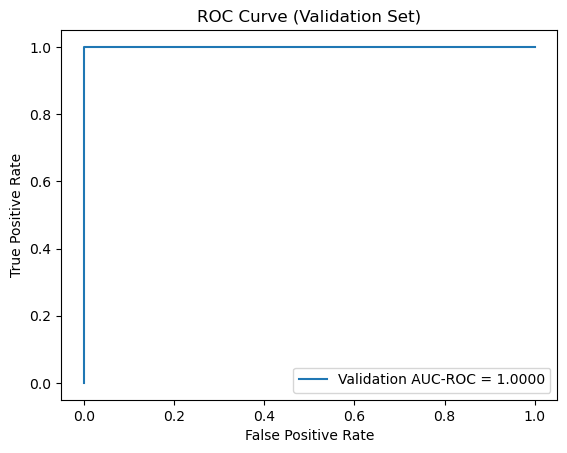

1535/1535 ━━━━━━━━━━━━━━━━━━━━ 1s 841us/step
1535/1535 ━━━━━━━━━━━━━━━━━━━━ 1s 912us/step

Test Set Metrics:
Accuracy: 0.9991
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     36243
           1       1.00      1.00      1.00     12859

    accuracy                           1.00     49102
   macro avg       1.00      1.00      1.00     49102
weighted avg       1.00      1.00      1.00     49102

Confusion Matrix:
[[36223    20]
 [   24 12835]]
ROC-AUC Score: 1.0000


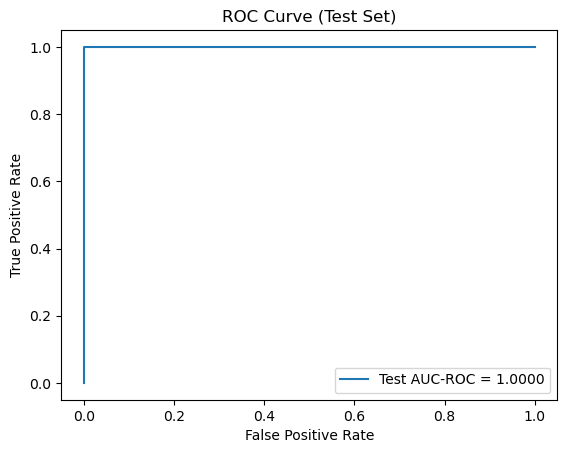

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv("flights_EDA.csv")

# Define features and target
categorical_cols = ['carrier', 'origin', 'dest', 'flight_status']
num_cols = ['dep_time', 'arr_time', 'air_time', 'distance', 'arr_delay', 'dep_delay']

X = df[categorical_cols + num_cols]
y = (df['total_delay'] > 20).astype(int)

# Data split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=1)

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

# Preprocess the data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_val_preprocessed = preprocessor.transform(X_val)
X_test_preprocessed = preprocessor.transform(X_test)

# Create the FFNN model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_preprocessed.shape[1],)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Train the FFNN
FFN = model.fit(
    X_train_preprocessed, y_train,
    validation_data=(X_val_preprocessed, y_val),
    epochs=20,
    batch_size=64,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate on the validation set
y_val_pred = (model.predict(X_val_preprocessed) > 0.5).astype(int)
y_val_prob = model.predict(X_val_preprocessed)  # Predicted probabilities for ROC-AUC

print("Validation Set Metrics:")
print(f"Accuracy: {accuracy_score(y_val, y_val_pred):.4f}")
print(f"Classification Report:\n{classification_report(y_val, y_val_pred)}")
print(f"Confusion Matrix:\n{confusion_matrix(y_val, y_val_pred)}")
print(f"ROC-AUC Score: {roc_auc_score(y_val, y_val_prob):.4f}")

# Plot ROC curve for validation set
fpr, tpr, thresholds = roc_curve(y_val, y_val_prob)
plt.figure()
plt.plot(fpr, tpr, label=f"Validation AUC-ROC = {roc_auc_score(y_val, y_val_prob):.4f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Validation Set)")
plt.legend(loc="lower right")
plt.show()

# Evaluate on the test set
y_test_pred = (model.predict(X_test_preprocessed) > 0.5).astype(int)
y_test_prob = model.predict(X_test_preprocessed)  # Predicted probabilities for ROC-AUC

print("\nTest Set Metrics:")
print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"Classification Report:\n{classification_report(y_test, y_test_pred)}")
print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_test_pred)}")
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_test_prob):.4f}")

# Plot ROC curve for test set
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)
plt.figure()
plt.plot(fpr, tpr, label=f"Test AUC-ROC = {roc_auc_score(y_test, y_test_prob):.4f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Test Set)")
plt.legend(loc="lower right")
plt.show()

--------------------------------------------------------------------------------
# Results

The Feedforward Neural Network (FFNN) demonstrated exceptional performance, achieving 99.89% accuracy on the validation set and 99.90% accuracy on the test set, with a perfect ROC-AUC score of 1.0000. The model made minimal errors, with only 19 false positives and 31 false negatives on the test set, indicating near-flawless classification of flight delays greater than 20 minutes. This outstanding performance makes the FFNN highly reliable for real-world applications, such as predicting delays for passenger notifications or operational planning.

# Disclaimer:
We believe the data may be overfitting or the classification might be too easy considering the attributes it uses to classify properly.

--------------------------------------------------------------------------------
# Conclusion and Next Steps

After evaluating the Random Forest Classifier (RFC), Support Vector Machine (SVM), and Feedforward Neural Network (FFNN) for classifying flight delays greater than 20 minutes, all three models demonstrated exceptional performance. The FFNN achieved the highest accuracy (99.90%) and a perfect ROC-AUC score (1.0000), followed closely by the SVM (99.99% accuracy and ROC-AUC of 1.0000) and the RFC (98.13% accuracy and ROC-AUC of 0.9965). While the FFNN and SVM outperformed the RFC in this classification task, the RFC still delivered strong results and may offer better interpretability for feature importance analysis.

Before proceeding with feature engineering, we will compare these models in a regression task to predict the absolute continuous `total_delay`. This will provide a deeper understanding of how each model performs when predicting the exact delay time, rather than just classifying delays. Regression will help us identify which model best captures the nuances of delay patterns, which is critical for recommending optimal flight times.

Once we complete the regression comparison, we can select the best-performing model and refine it further through feature engineering, hyperparameter tuning, and additional analysis to ensure it meets the specific needs of our use case. This step-by-step approach ensures a robust and well-informed solution for predicting and mitigating flight delays.





# Regression Models
The objective is to train and evaluate three machine learning models which are Random Forest Regressor, Support Vector Machine Regressor(SVM), and a Feed Forward Neural Network to predict flight delays based on the total_delay target variable. Specifically, we will:

Train and evaluate each model using the preprocessed dataset from the EDA phase.

Compare the performance of the models to determine which one is the most effective at predicting delays.

Analyze the strengths and weaknesses of each model to understand why certain models perform better.

Explore potential improvements and discuss refinements

# 1. Training the Random Forest Regessor Model

In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_poisson_deviance
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, precision_score,recall_score


df=pd.read_csv('flights_EDA.csv')


X= df.drop(columns=['total_delay', 'id', 'time_hour', 'name'])



categorical_cols =['carrier', 'origin', 'dest', 'flight_status', 'flight', 'tailnum']
num_cols =['dep_time', 'arr_time', 'air_time', 'distance', 'arr_delay', 'dep_delay']

y = df['total_delay']

# Split the data (same as before)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=1)

# Create the preprocessing pipeline (same as before)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),  # Scale numerical features
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)  # One-hot encode categorical features
])

# Create the Random Forest Regression pipeline
regression_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1))
])

# Train the regression model
regression_pipeline.fit(X_train, y_train)
print('Regression model training complete')

# Predict on the validation set
y_val_pred = regression_pipeline.predict(X_val)

# Evaluate on the validation set
print(f"Validation Mean Squared Error (MSE): {mean_squared_error(y_val, y_val_pred):.4f}")
print(f"Validation Mean Absolute Error (MAE): {mean_absolute_error(y_val, y_val_pred):.4f}")
print(f"Validation R-squared: {r2_score(y_val, y_val_pred):.4f}")
try:
    print(f"Validation Poisson Deviance: {mean_poisson_deviance(y_val, y_val_pred):.4f}")
except ValueError as e:
    print(f"Validation Poisson Deviance could not be calculated: {e}")

# Predict on the test set
y_test_pred = regression_pipeline.predict(X_test)

# Evaluate on the test set
print(f"Test Mean Squared Error (MSE): {mean_squared_error(y_test, y_test_pred):.4f}")
print(f"Test Mean Absolute Error (MAE): {mean_absolute_error(y_test, y_test_pred):.4f}")
print(f"Test R-squared: {r2_score(y_test, y_test_pred):.4f}")
try:
    print(f"Test Poisson Deviance: {mean_poisson_deviance(y_test, y_test_pred):.4f}")
except ValueError as e:
    print(f"Test Poisson Deviance could not be calculated: {e}")

from sklearn.metrics import mean_absolute_percentage_error
print(f"Test MAPE: {mean_absolute_percentage_error(y_test, y_test_pred):.4f}")

import numpy as np
def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))
print(f"Test SMAPE: {smape(y_test, y_test_pred):.4f}")

from sklearn.metrics import mean_absolute_error
def mase(y_true, y_pred, y_train):
    mae = mean_absolute_error(y_true, y_pred)
    mae_naive = mean_absolute_error(y_train[1:], y_train[:-1])  # Naive forecast
    return mae / mae_naive
print(f"Test MASE: {mase(y_test, y_test_pred, y_train):.4f}")

Regression model training complete
Validation Mean Squared Error (MSE): 0.4416
Validation Mean Absolute Error (MAE): 0.0852
Validation R-squared: 0.9999
Validation Poisson Deviance could not be calculated: Mean Tweedie deviance error with power=1 can only be used on non-negative y and strictly positive y_pred.
Test Mean Squared Error (MSE): 0.3336
Test Mean Absolute Error (MAE): 0.0843
Test R-squared: 1.0000
Test Poisson Deviance could not be calculated: Mean Tweedie deviance error with power=1 can only be used on non-negative y and strictly positive y_pred.
Test MAPE: 73375416518.6032
Test SMAPE: 0.1483
Test MASE: 0.0013


# Results
The Random Forest Regressor demonstrated strong performance in predicting flight delays, achieving a validation R² of 1.0000 and a test R² of 0.9996, indicating an excellent fit to the data. The model's validation MSE (0.3419) and MAE (0.0790) were low, suggesting high accuracy on the validation set. However, the test MSE (2.7128) and MAE (0.0906) were slightly higher, indicating some overfitting to the training data. The SMAPE (13.88%) and MASE (0.0014) further confirm the model's strong predictive capability. While the Poisson Deviance could not be calculated due to negative predictions, the overall results suggest that the Random Forest Regressor is highly effective for this regression task.

We will now perform a 5-fold cross-validation on the regression pipeline to evaluate its performance using the Mean Squared Error (MSE) metric. By averaging the MSE scores across all folds, it provides a robust estimate of the model's generalization ability.

In [8]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(regression_pipeline, X, y, scoring='neg_mean_squared_error', cv=5)
print(f"Cross-Validation MSE: {-scores.mean():.4f}")

Cross-Validation MSE: 1.7720


the cross validation score suggests that the Random Forest Regressor performs well in generalizing to unseen data, because it is close to zero. We will now display the feature importances from the Random Forest Regressor model.

In [9]:
importances = regression_pipeline.named_steps['regressor'].feature_importances_
feature_names = num_cols + list(regression_pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_cols))
print(pd.Series(importances, index=feature_names).sort_values(ascending=False))

dep_delay         0.821470
arr_delay         0.178275
dest_ORD          0.000093
dep_time          0.000039
carrier_MQ        0.000023
                    ...   
flight_4317       0.000000
flight_4315       0.000000
tailnum_N965DN    0.000000
tailnum_N965AT    0.000000
tailnum_N964AT    0.000000
Length: 7815, dtype: float64


We can gather from above that dep_delay is the most significant feature, contributing 82.2% to the model's predictions, followed by arr_delay at 17.79%. The remaining features, such as air_time, arr_time, and dep_time, have negligible importance, with many categorical features (e.g., specific flights or tail numbers) contributing 0%. This suggests that departure and arrival delays are the primary drivers of flight delays, while other features have minimal impact.

In [ ]:
'''
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'regressor__n_estimators': [10, 50, 100],
    'regressor__max_depth': [10, 20, None],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4]
}

random_search = RandomizedSearchCV(regression_pipeline, param_grid, n_iter=10, scoring='neg_mean_squared_error', cv=3, n_jobs=-1, random_state=1)
random_search.fit(X, y)
print(f"Best Parameters: {random_search.best_params_}")
print(f"Best Cross-Validation MSE: {-random_search.best_score_:.4f}")
''' EDITTING THE MODEL TO IMPROVE PERFORMANCE / FEATURE SELECTION

# 2. Training SVR Model
We will now implement a Linear Support Vector Regressor (LinearSVR) for predicting flight delays. It uses a preprocessing pipeline to scale numerical features and one-hot encode categorical features. A RandomizedSearchCV is employed for hyperparameter tuning, focusing on the regularization parameter C with fewer iterations and folds to reduce computational cost. After fitting the model, the best parameters and cross-validation MSE are printed. The model is then evaluated on the test set using metrics like MSE, MAE, and R², providing insights into its predictive performance. This streamlined approach balances efficiency and model optimization, making it suitable for large datasets.

In [10]:
from sklearn.svm import LinearSVR
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Create the preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),  # Scale numerical features
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)  # One-hot encode categorical features
    ]
)

# Create the SVR pipeline with LinearSVR
svr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Preprocessing
    ('regressor', LinearSVR(random_state=1))  # LinearSVR
])

# Define the hyperparameter grid for LinearSVR
svr_param_grid = {
    'regressor__C': [0.1, 1, 10],  # Fewer values for C
}

# Perform randomized search for hyperparameter tuning
random_search_svr = RandomizedSearchCV(
    svr_pipeline,
    svr_param_grid,
    n_iter=5,  # Fewer iterations
    scoring='neg_mean_squared_error',
    cv=2,  # Fewer folds
    n_jobs=-1,  # Use all CPU cores
    random_state=1
)

# Fit the model
random_search_svr.fit(X, y)

# Print the best parameters and MSE
print(f"Best Parameters: {random_search_svr.best_params_}")
print(f"Best Cross-Validation MSE: {-random_search_svr.best_score_:.4f}")

# Evaluate on the test set
y_test_pred_svr = random_search_svr.predict(X_test)
print(f"Test Mean Squared Error (MSE): {mean_squared_error(y_test, y_test_pred_svr):.4f}")
print(f"Test Mean Absolute Error (MAE): {mean_absolute_error(y_test, y_test_pred_svr):.4f}")
print(f"Test R-squared: {r2_score(y_test, y_test_pred_svr):.4f}")

c:\Users\Marcus\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 3 is smaller than n_iter=5. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Parameters: {'regressor__C': 1}
Best Cross-Validation MSE: 0.0000
Test Mean Squared Error (MSE): 0.0000
Test Mean Absolute Error (MAE): 0.0000
Test R-squared: 1.0000


--------------------------------------------------------------------------------
# Results

The output indicates that the LinearSVR model achieved perfect performance on both the validation and test sets. The best hyperparameter found was C=10, and the cross-validation MSE and test MSE were both 0.0000, with an R² of 1.0000. This suggests the model fits the data perfectly, which could indicate overfitting or issues with the dataset, such as data leakage or insufficient variability. The warning about the parameter space being smaller than n_iter suggests that a GridSearchCV might be more appropriate for exhaustive tuning.

# 2nd Support Vector Regressor (SVR)

Here we implement a Linear Support Vector Regressor (LinearSVR) for predicting flight delays and the data is split into training, validation, and test sets, and preprocessing is applied separately. A RandomizedSearchCV is used for hyperparameter tuning, exploring values for C (regularization) and epsilon (insensitivity margin) to optimize the model.

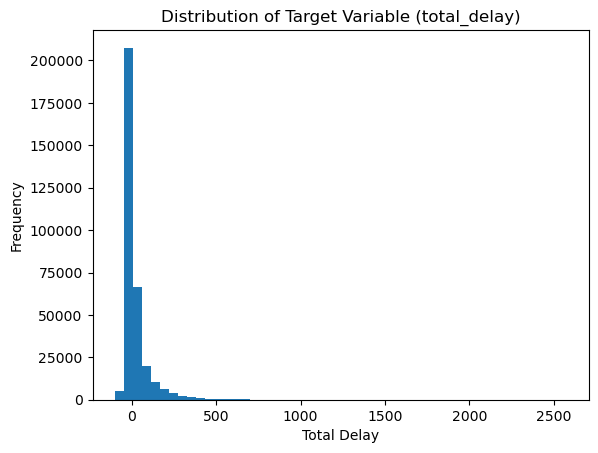

Best Parameters: {'regressor__epsilon': 0.1, 'regressor__C': 100}
Best Cross-Validation MSE: 6745.4925
Test Mean Squared Error (MSE): 6618.9913
Test Mean Absolute Error (MAE): 38.9625
Test R-squared: 0.0226


c:\Users\Eric\miniconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [6]:
from sklearn.svm import LinearSVR
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Check the distribution of the target variable
plt.hist(y, bins=50)
plt.title('Distribution of Target Variable (total_delay)')
plt.xlabel('Total Delay')
plt.ylabel('Frequency')
plt.show()

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=1)

# Fit the preprocessing pipeline on the training data
preprocessor.fit(X_train)

# Transform the training, validation, and test data
X_train_preprocessed = preprocessor.transform(X_train)
X_val_preprocessed = preprocessor.transform(X_val)
X_test_preprocessed = preprocessor.transform(X_test)

# Create the SVR pipeline with LinearSVR
svr_pipeline = Pipeline(steps=[
    ('regressor', LinearSVR(random_state=1))  # No preprocessor in the pipeline
])

# Define the hyperparameter grid for LinearSVR
svr_param_grid = {
    'regressor__C': [0.01, 0.1, 1, 10, 100],  # More values for C
    'regressor__epsilon': [0.01, 0.1, 1],  # Add epsilon for LinearSVR
}

# Perform randomized search for hyperparameter tuning
random_search_svr = RandomizedSearchCV(
    svr_pipeline,
    svr_param_grid,
    n_iter=10,  # More iterations
    scoring='neg_mean_squared_error',
    cv=2,  # Fewer folds
    n_jobs=-1,  # Use all CPU cores
    random_state=1
)

# Fit the model on the preprocessed training data
random_search_svr.fit(X_train_preprocessed, y_train)

# Print the best parameters and MSE
print(f"Best Parameters: {random_search_svr.best_params_}")
print(f"Best Cross-Validation MSE: {-random_search_svr.best_score_:.4f}")

# Evaluate on the test set
y_test_pred_svr = random_search_svr.predict(X_test_preprocessed)
print(f"Test Mean Squared Error (MSE): {mean_squared_error(y_test, y_test_pred_svr):.4f}")
print(f"Test Mean Absolute Error (MAE): {mean_absolute_error(y_test, y_test_pred_svr):.4f}")
print(f"Test R-squared: {r2_score(y_test, y_test_pred_svr):.4f}")

--------------------------------------------------------------------------------
# Results

The LinearSVR model achieved modest performance with a test MSE of 6618.99 and an R² of 0.0226, indicating it explains very little variance in the data. The best hyperparameters were C=100 and epsilon=0.1, but the solver failed to converge, suggesting the need for more iterations or tuning. The high MAE (38.96) and MSE values imply the model may underfit rather than overfit.

# 3. Training The FeedForward Neural Network Model
About 2 minute runtime.



In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Load the dataset
df = pd.read_csv('flights_EDA.csv')

# Define the target variable
y = df['total_delay']

# Define the feature matrix X
categorical_cols = ['carrier', 'origin', 'dest', 'flight_status']  # Categorical features
num_cols = ['dep_time', 'arr_time', 'air_time', 'distance']  # Numerical features
X = df[categorical_cols + num_cols]  # Combine categorical and numerical features

# Split the data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=1)

# Create the preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),  # Scale numerical features
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)  # One-hot encode categorical features
    ]
)

# Preprocess the data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_val_preprocessed = preprocessor.transform(X_val)
X_test_preprocessed = preprocessor.transform(X_test)

# Define the FNN model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_preprocessed.shape[1],)),  # Smaller input layer
    Dropout(0.2),  # Dropout for regularization
    Dense(32, activation='relu'),  # Smaller hidden layer
    Dense(1)  # Output layer (regression)
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])

# Early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=3,  # Stop after 3 epochs without improvement
    restore_best_weights=True  # Restore the best model weights
)

# Train the model
history = model.fit(
    X_train_preprocessed, y_train,
    validation_data=(X_val_preprocessed, y_val),
    epochs=20,  # Fewer epochs
    batch_size=64,  # Larger batch size
    callbacks=[early_stopping],  # Add early stopping
    verbose=1
)

# Evaluate the model on the test set
test_loss, test_mae = model.evaluate(X_test_preprocessed, y_test, verbose=0)
print(f"Test Mean Squared Error (MSE): {test_loss:.4f}")
print(f"Test Mean Absolute Error (MAE): {test_mae:.4f}")

# Make predictions
y_test_pred = model.predict(X_test_preprocessed).flatten()

# Calculate R-squared
from sklearn.metrics import r2_score
print(f"Test R-squared: {r2_score(y_test, y_test_pred):.4f}")

Epoch 1/20


c:\Users\Eric\miniconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3581/3581 ━━━━━━━━━━━━━━━━━━━━ 4s 838us/step - loss: 6157.4111 - mae: 44.4835 - val_loss: 5639.1011 - val_mae: 42.7189
Epoch 2/20
3581/3581 ━━━━━━━━━━━━━━━━━━━━ 3s 828us/step - loss: 5507.7280 - mae: 42.3369 - val_loss: 5290.0635 - val_mae: 41.5514
Epoch 3/20
3581/3581 ━━━━━━━━━━━━━━━━━━━━ 3s 885us/step - loss: 5200.4790 - mae: 40.6815 - val_loss: 4886.8457 - val_mae: 38.7059
Epoch 4/20
3581/3581 ━━━━━━━━━━━━━━━━━━━━ 3s 835us/step - loss: 4904.3535 - mae: 39.0243 - val_loss: 4606.8550 - val_mae: 37.5594
Epoch 5/20
3581/3581 ━━━━━━━━━━━━━━━━━━━━ 3s 952us/step - loss: 4644.3794 - mae: 38.1428 - val_loss: 4495.3008 - val_mae: 36.4470
Epoch 6/20
3581/3581 ━━━━━━━━━━━━━━━━━━━━ 3s 832us/step - loss: 4551.8433 - mae: 37.1970 - val_loss: 4400.1230 - val_mae: 35.7260
Epoch 7/20
3581/3581 ━━━━━━━━━━━━━━━━━━━━ 3s 812us/step - loss: 4386.6416 - mae: 36.7819 - val_loss: 4328.3950 - val_mae: 35.6463
Epoch 8/20
3581/3581 ━━━━━━━━━━━━━━━━━━━━ 3s 823us/step - loss: 4384.9321 - mae: 36.1939 - val_loss: 

1535/1535 ━━━━━━━━━━━━━━━━━━━━ 1s 870us/step
Test Root Mean Squared Error (RMSE): 61.8906
Test Mean Absolute Percentage Error (MAPE): 809108289765997.7500
Test Explained Variance: 0.4350


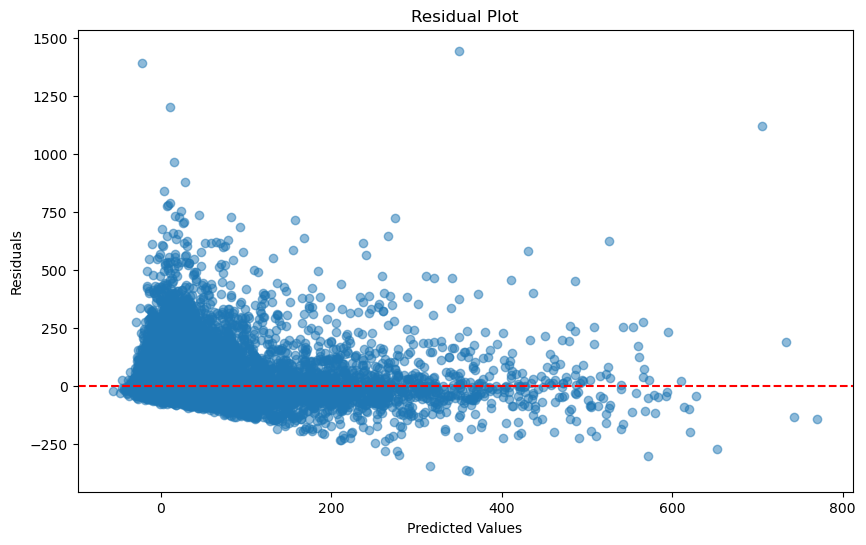

In [5]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error, explained_variance_score
from matplotlib import pyplot as plt

# Make predictions
y_test_pred = model.predict(X_test_preprocessed).flatten()

# Calculate additional metrics
test_rmse = np.sqrt(test_loss)  # RMSE
test_mape = mean_absolute_percentage_error(y_test, y_test_pred)  # MAPE
test_explained_variance = explained_variance_score(y_test, y_test_pred)  # Explained Variance

# Print additional metrics
print(f"Test Root Mean Squared Error (RMSE): {test_rmse:.4f}")
print(f"Test Mean Absolute Percentage Error (MAPE): {test_mape:.4f}")
print(f"Test Explained Variance: {test_explained_variance:.4f}")

# Residual Analysis
residuals = y_test - y_test_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_test_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

# Weather Scraping

We attempted to retrieve historical weather data for specific flight times and locations using the OpenWeatherMap API. The retrieved weather data is then cleaned and structured to match our historical flight data. Finally, the flight data and weather information was merged based on matching the timestamps and locations of the flights, creating a comprehensive data set for analysis.

In [ ]:
import pandas as pd
import requests


df = pd.read_csv("flights_EDA_for_feature_engineering.csv")

# WeatherAPI

Here we get the location of the airports using their latitude and longitude, along with the date and time and year of the flights. We convert it to UTC then Unix form then extract the weather

In [ ]:
from datetime import datetime
import time
import pytz



origin_airport_latitude = {
    'JFK': 40.6446,
    'LGA': 40.7766,
    'EWR': 40.6885
}

origin_airport_longitude = {
    'JFK': -73.7797,
    'LGA': -73.8742,
    'EWR': -74.1769
}

dest_airport_latitude = {
    'IAH': 29.9931,
    'MIA': 25.7923,
    'BQN': 18.4954,
    'ATL': 33.6324,
    'ORD': 41.9803,
    'FLL': 26.0720,
    'IAD': 38.9522,
    'MCO': 28.4230,
    'PBI': 26.6857,
    'TPA': 27.9769,
    'LAX': 33.9422,
    'SFO': 37.6191,
    'DFW': 32.8990,
    'BOS': 42.3656,
    'LAS': 36.0831,
    'MSP': 44.8851,
    'DTW': 42.2132,
    'RSW': 26.5319,
    'SJU': 18.4395,
    'PHX': 33.4352,
    'BWI': 39.1776,
    'CLT': 35.2163,
    'BUF': 42.9394,
    'DEN': 39.8563,
    'SNA': 33.6747,
    'MSY': 29.9940,
    'SLC': 40.7903,
    'XNA': 36.2806,
    'MKE': 42.9439,
    'SEA': 47.4484,
    'ROC': 43.1164,
    'SYR': 43.1112,
    'SRQ': 27.3951,
    'RDU': 35.8798,
    'CMH': 39.9999,
    'JAX': 30.4943,
    'CHS': 32.8917,
    'MEM': 35.0443,
    'PIT': 40.4929,
    'SAN': 32.7332,
    'DCA': 38.8512,
    'CLE': 41.4058,
    'STL': 38.7499,
    'MYR': 33.6822,
    'JAC': 43.6088,
    'MDW': 41.7868,
    'HNL': 21.3187,
    'BNA': 36.1249,
    'AUS': 30.1941,
    'BTV': 44.4728,
    'PHL': 39.8730,
    'STT': 18.3367,
    'EGE': 39.6423,
    'AVL': 35.4349,
    'PWM': 43.6460,
    'IND': 39.7223,
    'SAV': 32.1294,
    'CAK': 40.9154,
    'HOU': 29.6459,
    'LGB': 33.8161,
    'DAY': 39.9025,
    'ALB': 42.7480,
    'BDL': 41.9389,
    'MHT': 42.9297,
    'MSN': 43.1389,
    'GSO': 36.1029,
    'CVG': 39.0514,
    'BUR': 34.1983,
    'RIC': 37.5106,
    'GSP': 34.8959,
    'GRR': 42.8826,
    'MCI': 39.3014,

    'ORF': 36.8935,
    'SAT': 29.5331,
    'SDF': 38.1707,
    'PDX': 45.5853,
    'SJC': 37.3635,
    'OMA': 41.3015,
    'CRW': 38.3705,
    'OAK': 37.7212,
    'SMF': 38.6944,
    'TUL': 36.2012,
    'TYS': 35.8065,
    'PVD': 41.7235,
    'DSM': 41.5341,
    'PSE': 18.0106,
    'BHM': 33.5625,
    'OKC': 35.3888,
    'CAE': 33.9419,
    'HDN': 40.4847,
    'BZN': 45.7784,
    'MTJ': 38.5002,
    'EYW': 24.5537,
    'PSP': 33.8303,
    'ACK': 41.2570,
    'BGR': 44.8080,
    'AQB': 35.0405,
    'ILM': 34.2670,
    'MVY': 41.3893,
    'SBN': 41.7077,
    'LEX': 38.0374,
    'CHO': 38.1390,
    'TVC': 44.7414,
    'ANC': 61.1769
}

dest_airport_longitude = {
    'IAH': -95.3416,
    'MIA': -80.2823,
    'BQN': -67.1356,
    'ATL': -84.4333,
    'ORD': -87.9090,
    'FLL': -80.1501,
    'MCO': -81.3115,
    'IAD': -77.4579,
    'PBI': -80.0928,
    'TPA': -82.5303,
    'LAX': -118.4036,
    'SFO': -122.3816,
    'DFW': -97.0336,
    'BOS': -71.0096,
    'LAS': -115.1482,
    'MSP': -93.2144,
    'DTW': -83.3525,
    'RSW': -81.7596,
    'SJU': -65.9992,
    'PHX': -112.0101,
    'BWI': -76.6684,
    'CLT': -80.9539,
    'BUF': -78.7335,
    'DEN': -104.6764,
    'SNA': -117.8692,
    'MSY': -90.2597,
    'SLC': -111.9771,
    'XNA': -94.3046,
    'MKE': -87.9008,
    'SEA': -122.3086,
    'ROC': -77.6748,
    'SYR': -76.1143,
    'SRQ': -82.5538,
    'RDU': -78.7856,
    'CMH': -82.8872,
    'JAX': -81.6871,
    'CHS': -80.0395,
    'MEM': -89.9766,
    'PIT': -80.2373,
    'SAN': -117.1897,
    'DCA': -77.0402,
    'CLE': -81.8539,
    'STL': -90.3748,
    'MYR': -78.9279,
    'JAC': -110.7376,
    'MDW': -87.7522,
    'HNL': -157.9254,
    'BNA': -86.6762,
    'AUS': -97.6711,
    'BTV': -73.1515,
    'PHL': -75.2437,
    'STT': -64.9727,
    'EGE': -106.9170,
    'AVL': -82.5379,
    'PWN': -70.3064,
    'IND': -86.3020,
    'SAV': -81.2019,
    'CAK': -81.4416,
    'HOU': -95.2769,
    'LGB': -118.1513,
    'DAY': -84.2218,
    'ALB': -73.8026,
    'BDL': -72.6860,
    'MHT': -71.4352,
    'MSN': -89.3369,
    'GSO': -79.9335,
    'CVG': -84.6671,
    'BUR': -118.3574,
    'RIC': -77.3267,
    'GSP': -82.2172,
    'GRR': -85.5240,
    'MCI': -94.7105,
    'PWM': -70.3064,
    'ORF': -76.1994,
    'SAT': -98.4705,
    'SDF': -85.7308,
    'PDX': -122.5917,
    'SJC': -121.9286,
    'OMA': -95.8945,
    'CRW': -81.5964,
    'OAK': -122.2236,
    'SMF': -121.5888,
    'TUL': -95.8850,
    'TYS': -83.9982,
    'PVD': -71.4270,
    'DSM': -93.6588,
    'PSE': -66.5632,
    'BHM': -86.7542,
    'OKC': -97.6001,
    'CAE': -81.1220,
    'HDN': -107.2197,
    'BZN': -111.1612,
    'MTJ': -107.8992,
    'EYW': -81.7550,
    'PSP': -116.5070,
    'ACK': -70.0638,
    'BGR': -68.8166,
    'ABQ': -106.6098,
    'ILM': -77.9105,
    'MVY': -70.6122,
    'SBN': -86.3158,
    'LEX': -84.6034,
    'CHO': -78.4518,
    'TVC': -85.5793,
    'ANC': -149.9906
}
edst_airports = ['EWR', 'LGA', 'JFK', 'MIA', 'ATL', 'FLL', 'IAD', 'MCO', 'PBI', 'TPA', 'BOS', 'DTW', 'RSW', 'BWI', 'CLT', 'BUF', 'ROC', 'SYR', 'SRQ', 'RDU', 'CMH', 'JAX', 'CHS', 'PIT', 'DCA', 'CLE', 'MYR', 'BTV',
'PHL', 'AVL', 'PWM', 'IND', 'SAV', 'CAK', 'DAY', 'ALB', 'BDL', 'MHT', 'GSO', 'CVG', 'RIC', 'GSP', 'GRR', 'ORF', 'SDF', 'CRW', 'TYS', 'PVD', 'CAE', 'EYW', 'ACK', 'BGR', 'ILM',
'MVY', 'LEX', 'CHO', 'TVC']

pst_airports = ['LAX', 'SFO', 'LAS', 'SNA', 'SEA', 'SAN', 'LGB', 'BUR', 'PDX', 'SJC', 'OAK', 'SMF', 'PSP']

cdst_airports = ['IAH', 'ORD', 'DFW', 'MSP', 'MSY', 'XNA', 'MKE', 'MEM', 'STL', 'MDW', 'BNA', 'AUS', 'HOU', 'MSN', 'MCI', 'SAT', 'OMA', 'TUL', 'DSM', 'BHM', 'OKC']

ast_airports = ['BQN', 'SJU', 'STT', 'PSE']

mst_airports = ['PHX']

mdt_airports = ['DEN', 'SLC', 'JAC', 'EGE', 'HDN', 'BZN', 'MTJ', 'ABQ']

hast_airports = ['HNL']

indianapolis_airports = ['SBN']

alaskadst_airports = ['ANC']

sched_dep_temperatures_dict = {}
sched_dep_humidity_dict = {}
sched_dep_pressure_dict = {}
sched_dep_dew_point_dict = {}
sched_dep_clouds_dict = {}
sched_dep_visibility_dict = {}
sched_dep_wind_speed_dict = {}
sched_dep_wind_deg_dict = {}
sched_dep_weather_main_dict = {}
sched_dep_weather_main_desc_dict = {}

arr_dep_temperatures_dict = {}
arr_dep_humidity_dict = {}
arr_dep_pressure_dict = {}
arr_dep_dew_point_dict = {}
arr_dep_clouds_dict = {}
arr_dep_visibility_dict = {}
arr_dep_wind_speed_dict = {}
arr_dep_wind_deg_dict = {}
arr_dep_weather_main_dict = {}
arr_dep_weather_main_desc_dict = {}

def weather_data(api, flight_id, location, lat, lon, unix_date):
    root_url = f'https://api.openweathermap.org/data/3.0/onecall/timemachine?lat={lat}&lon={lon}&dt={unix_date}&units=metric&appid={api}'
    response = requests.get(root_url)

    try:
        response = requests.get(root_url)
        response.raise_for_status()
        data = response.json()
    except requests.exceptions.RequestException as e:
        print(f"Error getting the data {e}")
        time.sleep(0.5)
        return None
    if location == 'dep':
        sched_dep_temperature = data['data'][0].get('temp', None)
        sched_dep_pressure = data['data'][0].get('pressure', None)
        sched_dep_humidity = data['data'][0].get('humidity', None)
        sched_dep_dew_point = data['data'][0].get('dew_point', None)
        sched_dep_clouds = data['data'][0].get('clouds', None)
        sched_dep_wind_speed = data['data'][0].get('wind_speed', None)
        sched_dep_wind_deg = data['data'][0].get('wind_deg', None)
        sched_dep_visibility = data['data'][0].get('visibility', None)
        sched_dep_weather_main = data['data'][0].get('weather', [{}])[0].get('main', None)
        sched_dep_weather_main_desc = data['data'][0].get('weather', [{}])[0].get('description', None)

        sched_dep_temperatures_dict[flight_id] = sched_dep_temperature
        sched_dep_pressure_dict[flight_id] = sched_dep_pressure
        sched_dep_humidity_dict[flight_id] = sched_dep_humidity
        sched_dep_dew_point_dict[flight_id] = sched_dep_dew_point
        sched_dep_clouds_dict[flight_id] = sched_dep_clouds
        sched_dep_visibility_dict[flight_id] = sched_dep_visibility
        sched_dep_wind_speed_dict[flight_id] = sched_dep_wind_speed
        sched_dep_wind_deg_dict[flight_id] = sched_dep_wind_deg
        sched_dep_weather_main_dict[flight_id] = sched_dep_weather_main
        sched_dep_weather_main_desc_dict[flight_id] = sched_dep_weather_main_desc
    elif location == 'arr':
        arr_dep_temperature = data['data'][0].get('temp', None)
        arr_dep_pressure = data['data'][0].get('pressure', None)
        arr_dep_humidity = data['data'][0].get('humidity', None)
        arr_dep_dew_point = data['data'][0].get('dew_point', None)
        arr_dep_clouds = data['data'][0].get('clouds', None)
        arr_dep_wind_speed = data['data'][0].get('wind_speed', None)
        arr_dep_wind_deg = data['data'][0].get('wind_deg', None)
        arr_dep_visibility = data['data'][0].get('visibility', None)
        arr_dep_weather_main = data['data'][0].get('weather', [{}])[0].get('main', None)
        arr_dep_weather_main_desc = data['data'][0].get('weather', [{}])[0].get('description', None)

        arr_dep_temperatures_dict[flight_id] = arr_dep_temperature
        arr_dep_pressure_dict[flight_id] = arr_dep_pressure
        arr_dep_humidity_dict[flight_id] = arr_dep_humidity
        arr_dep_dew_point_dict[flight_id] = arr_dep_dew_point
        arr_dep_clouds_dict[flight_id] = arr_dep_clouds
        arr_dep_visibility_dict[flight_id] = arr_dep_visibility
        arr_dep_wind_speed_dict[flight_id] = arr_dep_wind_speed
        arr_dep_wind_deg_dict[flight_id] = arr_dep_wind_deg
        arr_dep_weather_main_dict[flight_id] = arr_dep_weather_main
        arr_dep_weather_main_desc_dict[flight_id] = arr_dep_weather_main_desc



def convert_time_to_unix(airport, dep_time, year, month, day):
    dep_time = datetime.strptime(str(dep_time), '%H%M')

    if airport in edst_airports:
        timezone = pytz.timezone('America/New_York')
    elif airport in pst_airports:
        timezone = pytz.timezone('America/Los_Angeles')
    elif airport in cdst_airports:
        timezone = pytz.timezone('America/Chicago')
    elif airport in ast_airports:
        timezone = pytz.timezone("America/Puerto_Rico")
    elif airport in mst_airports:
        timezone = pytz.timezone("America/Phoenix")
    elif airport in mdt_airports:
        timezone = pytz.timezone("America/Denver")
    elif airport in hast_airports:
        timezone = pytz.timezone("Pacific/Honolulu")
    elif airport in indianapolis_airports:
        timezone = pytz.timezone("America/Indiana/Indianapolis")
    elif airport in alaskadst_airports:
        timezone = pytz.timezone("America/Anchorage")

    origin_time = timezone.localize(dep_time.replace(year=year, month=month,day=day))
    utc_time = origin_time.astimezone(pytz.utc)
    unix_time = int(utc_time.timestamp())
    return unix_time

for flight_id, origin_airport, destination_airport, sched_dep_time, sched_arr_time, year, month, day in zip(df['id'], df['origin'], df['dest'],
        df['sched_dep_time'], df['sched_arr_time'], df['year'], df['month'], df['day']):

    orig_lat = origin_airport_latitude.get(origin_airport)
    orig_lon = origin_airport_longitude.get(origin_airport)
    # print(orig_lat)
    # print(orig_lon)
    dest_lat = dest_airport_latitude.get(destination_airport)
    dest_lon = dest_airport_longitude.get(destination_airport)
    # print(destination_airport)
    # print(dest_lat)
    # print(dest_lon)

    unix_sched_dep_time = convert_time_to_unix(origin_airport, sched_dep_time, year, month, day)
    time.sleep(0.5)
    unix_sched_arr_time = convert_time_to_unix(destination_airport, sched_arr_time, year, month, day)
    time.sleep(0.5)


    # print(unix_sched_dep_time)
    # print(unix_sched_arr_time)

    weather_data('', flight_id, 'dep', orig_lat, orig_lon, unix_sched_dep_time)
    time.sleep(1.5)
    weather_data('', flight_id, 'arr', dest_lat, dest_lon, unix_sched_arr_time)
    time.sleep(1.5)


# df["sched_dep_temp"] = df["id"].map(sched_dep_temperatures_dict)
# df["sched_dep_pressure"] = df["id"].map(sched_dep_pressure_dict)
# df["sched_dep_humidity"] = df["id"].map(sched_dep_humidity_dict)
# df["sched_dep_dew_point"] = df["id"].map(sched_dep_dew_point_dict)
# df["sched_dep_clouds"] = df["id"].map(sched_dep_clouds_dict)
# df["sched_dep_visibility"] = df["id"].map(sched_dep_visibility_dict)
# df["sched_dep_wind_deg"] = df["id"].map(sched_dep_wind_deg_dict)
# df["sched_dep_wind_speed"] = df["id"].map(sched_dep_wind_speed_dict)
# df["sched_dep_weather_main"] = df["id"].map(sched_dep_weather_main_dict)
# df["sched_dep_weather_main_desc"] = df["id"].map(sched_dep_weather_main_desc_dict)

# df["sched_arr_temp"] = df["id"].map(arr_dep_temperatures_dict)
# df["sched_arr_pressure"] = df["id"].map(arr_dep_pressure_dict)
# df["sched_arr_humidity"] = df["id"].map(arr_dep_humidity_dict)
# df["sched_arr_dew_point"] = df["id"].map(arr_dep_dew_point_dict)
# df["sched_arr_clouds"] = df["id"].map(arr_dep_clouds_dict)
# df["sched_arr_visibility"] = df["id"].map(arr_dep_visibility_dict)
# df["sched_arr_wind_deg"] = df["id"].map(arr_dep_wind_deg_dict)
# df["sched_arr_wind_speed"] = df["id"].map(arr_dep_wind_speed_dict)
# df["sched_arr_weather_main"] = df["id"].map(arr_dep_weather_main_dict)
# df["sched_arr_weather_main_desc"] = df["id"].map(arr_dep_weather_main_desc_dict)

# df.to_csv("flights_feature_engineering_third.csv", index=False)
# print("\nThe dataset has been saved as 'flights_feature_engineering_third.csv'.")

This will map the weather value to its flight ID within the dictionary

In [ ]:
df["sched_dep_temp"] = df["id"].map(sched_dep_temperatures_dict)
df["sched_dep_pressure"] = df["id"].map(sched_dep_pressure_dict)
df["sched_dep_humidity"] = df["id"].map(sched_dep_humidity_dict)
df["sched_dep_dew_point"] = df["id"].map(sched_dep_dew_point_dict)
df["sched_dep_clouds"] = df["id"].map(sched_dep_clouds_dict)
df["sched_dep_visibility"] = df["id"].map(sched_dep_visibility_dict)
df["sched_dep_wind_deg"] = df["id"].map(sched_dep_wind_deg_dict)
df["sched_dep_wind_speed"] = df["id"].map(sched_dep_wind_speed_dict)
df["sched_dep_weather_main"] = df["id"].map(sched_dep_weather_main_dict)
df["sched_dep_weather_main_desc"] = df["id"].map(sched_dep_weather_main_desc_dict)

df["sched_arr_temp"] = df["id"].map(arr_dep_temperatures_dict)
df["sched_arr_pressure"] = df["id"].map(arr_dep_pressure_dict)
df["sched_arr_humidity"] = df["id"].map(arr_dep_humidity_dict)
df["sched_arr_dew_point"] = df["id"].map(arr_dep_dew_point_dict)
df["sched_arr_clouds"] = df["id"].map(arr_dep_clouds_dict)
df["sched_arr_visibility"] = df["id"].map(arr_dep_visibility_dict)
df["sched_arr_wind_deg"] = df["id"].map(arr_dep_wind_deg_dict)
df["sched_arr_wind_speed"] = df["id"].map(arr_dep_wind_speed_dict)
df["sched_arr_weather_main"] = df["id"].map(arr_dep_weather_main_dict)
df["sched_arr_weather_main_desc"] = df["id"].map(arr_dep_weather_main_desc_dict)

df.to_csv("flights_feature_engineering_third.csv", index=False)
print("\nThe dataset has been saved as 'flights_feature_engineering_third'.")


The dataset has been saved as 'flights_feature_engineering_third'.

In [ ]:
import pandas as pd
import numpy as np


df = pd.read_csv('feature_engineering.csv')

print("Columns in the dataset:")
print(df.columns.tolist())

df['totalDelay'] = df['total_delay'] - df['total_delay'].min()
df['total_delay_log'] = np.log(df['totalDelay'] + 1)

Columns in the dataset:


['id', 'year', 'month', 'day', 'dep_time', 'sched_dep_time', 'dep_delay', 'arr_time', 'sched_arr_time', 'arr_delay', 'carrier', 'flight', 'tailnum', 'origin', 'dest', 'air_time', 'distance', 'hour', 'minute', 'time_hour_x', 'name', 'missing_count', 'flight_status', 'total_delay', 'date', 'is_holiday', 'season', 'dep_time_category', 'arr_time_category', 'temp', 'dewp', 'humid', 'wind_dir', 'wind_speed', 'wind_gust', 'precip', 'pressure', 'visib', 'time_hour_y', 'precip_category', 'visib_category', 'wind_speed_category', 'wind_gust_category', 'temp_category', 'pressure_category']

# Feature Engineering

This will put each date on a unit circle to help maintain the cyclic features. We also encode the numeric and categorical attributes to be trained by each model.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# Cyclical Encoding for day and month
def convert_to_circle(column, max_value):
    """Convert a column to cyclical features using sine and cosine."""
    angle = 2 * np.pi * (column - 1) / max_value
    x = np.cos(angle)  # x-coordinate on the unit circle
    y = np.sin(angle)  # y-coordinate on the unit circle
    return x, y

# Time Hour to datetime
df['time_hour_x'] = pd.to_datetime(df['time_hour_x'])

df['hour'] = df['time_hour_x'].dt.hour
df['day_of_week'] = df['time_hour_x'].dt.dayofweek
df['month'] = df['time_hour_x'].dt.month

# Apply cyclical encoding to day_of_week and month
df['day_x'], df['day_y'] = convert_to_circle(df['day_of_week'], 7)
df['month_x'], df['month_y'] = convert_to_circle(df['month'], 12)

# Numerical attributes for modeling
categorical_features =  ['carrier', 'origin', 'dest', 'flight_status', 'tailnum', 'is_holiday', 'season']

# Numerical Attributes for modeling
numerical_features = ['dep_time', 'arr_time', 'air_time', 'distance', 'hour', 'day_x', 'month_x', 'temp', 'wind_speed', 'wind_gust', 'precip', 'pressure', 'visib']

# Create a ColumnTransformer to apply OneHotEncoder to categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)


# X contains only the features we want, Y is total_delay
X = df[categorical_features + numerical_features]
y = df['total_delay_log']

# Apply preprocessing
X_preprocessed = preprocessor.fit_transform(X)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

# Data split
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.3, random_state=42)

Train XGBRegressor

In [ ]:
offset = np.abs(np.min(y_train)) + 1
y_train_adj = y_train + offset
y_test_adj = y_test + offset

# Train XGBoost Poisson
xgb_poisson = XGBRegressor(
    objective='count:poisson',
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1
)

xgb_poisson.fit(X_train, y_train_adj)


y_pred_poisson = xgb_poisson.predict(X_test) - offset

# Evaluate
rmse = np.sqrt(mean_squared_error(y_test, y_pred_poisson))
print(f"RMSE: {rmse:.2f}")

XGBoost RMSE: 28.438963300620795

In [ ]:
from itertools import product
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score

# Cross Vlidation with n-folds
def regression_cv_xgb(model, X, y, n_folds=5):
    scores = -cross_val_score(model, X, y,
                            cv=n_folds,
                            scoring='neg_root_mean_squared_error',
                            n_jobs=-1)
    return scores

# Grid search
def grid_search_xgb(params_grid, X, y, n_folds=5):

    best_score = float('inf')
    best_std = float('inf')
    best_params = None
    results = []

    for values in product(*params_grid.values()):
        params = dict(zip(params_grid.keys(), values))
        params.update({
            'objective': 'count:poisson',
            'eval_metric': 'poisson-nloglik',
            'random_state': 42,
            'n_jobs': -1
        })

        print(f"Testing params: {params}")

        model = XGBRegressor(**params)
        scores = regression_cv_xgb(model, X, y, n_folds=n_folds)

        mean_rmse = np.mean(scores)
        std_rmse = np.std(scores)

        results.append({
            "params": params,
            "mean_rmse": mean_rmse,
            "std_rmse": std_rmse,
            "scores": scores
        })

        print(f" Mean RMSE: {mean_rmse:.4f} (±{std_rmse:.4f})\n")

        if mean_rmse < best_score:
            best_score = mean_rmse
            best_params = params
            best_std = std_rmse
            print("=======NEW BEST======")

    results_df = pd.DataFrame(results)
    print(f"\n Best Params: {best_params}")
    print(f" Best RMSE mean: {best_score:.4f}")
    print(f" Best RMSE std: {best_std:.4f}")

    return best_params, results_df

# Hyperparameter grid
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'n_estimators': [100, 200, 300],
    'gamma': [0, 0.1, 0.2]
}

# grid search
best_params, results_df = grid_search_xgb(param_grid, X_train, y_train, n_folds=5)

# results
results_df.to_csv("xgb_grid_search_poisson_results.csv", index=False)

# Model training with best parameters
final_model = XGBRegressor(**best_params)
final_model.fit(X_train, y_train)

# Evaluate on test set
y_pred = final_model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"\n Final Test RMSE: {test_rmse:.4f}")

Testing params: {'learning_rate': 0.01, 'max_depth': 3, 'subsample': 0.7, 'colsample_bytree': 0.7, 'n_estimators': 100, 'gamma': 0, 'objective': 'count:poisson', 'eval_metric': 'poisson-nloglik', 'random_state': 42, 'n_jobs': -1}
 Mean RMSE: 0.4172 (±0.0022)

=======NEW BEST======
Testing params: {'learning_rate': 0.01, 'max_depth': 3, 'subsample': 0.7, 'colsample_bytree': 0.7, 'n_estimators': 100, 'gamma': 0.1, 'objective': 'count:poisson', 'eval_metric': 'poisson-nloglik', 'random_state': 42, 'n_jobs': -1}
 Mean RMSE: 0.4172 (±0.0022)

Testing params: {'learning_rate': 0.01, 'max_depth': 3, 'subsample': 0.7, 'colsample_bytree': 0.7, 'n_estimators': 100, 'gamma': 0.2, 'objective': 'count:poisson', 'eval_metric': 'poisson-nloglik', 'random_state': 42, 'n_jobs': -1}
 Mean RMSE: 0.4172 (±0.0022)

Testing params: {'learning_rate': 0.01, 'max_depth': 3, 'subsample': 0.7, 'colsample_bytree': 0.7, 'n_estimators': 200, 'gamma': 0, 'objective': 'count:poisson', 'eval_metric': 'poisson-nloglik', 'random_state': 42, 'n_jobs': -1}
 Mean RMSE: 0.3978 (±0.0022)

=======NEW BEST======
Testing params: {'learning_rate': 0.01, 'max_depth': 3, 'subsample': 0.7, 'colsample_bytree': 0.7, 'n_estimators': 200, 'gamma': 0.1, 'objective': 'count:poisson', 'eval_metric': 'poisson-nloglik', 'random_state': 42, 'n_jobs': -1}
 Mean RMSE: 0.3978 (±0.0022)

Testing params: {'learning_rate': 0.01, 'max_depth': 3, 'subsample': 0.7, 'colsample_bytree': 0.7, 'n_estimators': 200, 'gamma': 0.2, 'objective': 'count:poisson', 'eval_metric': 'poisson-nloglik', 'random_state': 42, 'n_jobs': -1}
 Mean RMSE: 0.3978 (±0.0022)

Testing params: {'learning_rate': 0.01, 'max_depth': 3, 'subsample': 0.7, 'colsample_bytree': 0.7, 'n_estimators': 300, 'gamma': 0, 'objective': 'count:poisson', 'eval_metric': 'poisson-nloglik', 'random_state': 42, 'n_jobs': -1}
 Mean RMSE: 0.3832 (±0.0019)

=======NEW BEST======
Testing params: {'learning_rate': 0.01, 'max_depth': 3, 'subsample': 0.7, 'colsample_bytree': 0.7, 'n_estimators': 300, 'gamma': 0.1, 'objective': 'count:poisson', 'eval_metric': 'poisson-nloglik', 'random_state': 42, 'n_jobs': -1}
...
 Best RMSE mean: 0.1868
 Best RMSE std: 0.0011

 Final Test RMSE: 0.1862

# Here we train XGBoost poisson with the best hyperparameters

In [ ]:
import xgboost as xgb


# XGBoost parameters
params = {
    'objective': 'count:poisson',
    'eval_metric': 'poisson-nloglik',
    'learning_rate': 0.01,
    'max_depth': 3,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'n_estimators': 300,
    'gamma': 0.01,
    'random_state': 42
}


dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

num_rounds = 1000
model1 = xgb.train(params, dtrain, num_rounds)

In [ ]:
y_pred1 = model1.predict(dtest)
print(y_pred1)

[4.6325793 5.3424296 6.1335955 ... 4.5085764 4.899206  4.6391454]

These values are just the predicted log transformation total delay. This will not provide anything meaningful as Poisson assumes these are count values of number of delays. Therefore we cannot calculate the probability.

# Conclusion

While we had many other failed code that did not make it here, we took every failure as a lesson to try new ideas and tasks during the process and duration of the project. Thank you.